https://github.com/ual/rental-listings

This notebook analyzes the rental listings data set, computes several descriptive statistics, and visualizes market characteristics

## Initial setup

In [1]:
# import necessary modules and display matplotlib plots inline within the ipython notebook webpage
import pandas as pd, numpy as np, statsmodels.api as sm
import matplotlib.pyplot as plt, matplotlib.cm as cm, matplotlib.font_manager as fm
from scipy.stats import pearsonr, ttest_rel
%matplotlib inline

In [2]:
def get_colors(cmap, n, start=0., stop=1., alpha=1., reverse=False):
    '''return n-length list of rgba colors from the passed colormap name and alpha,
       limit extent by start/stop values and reverse list order if flag is true'''
    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return list(reversed(colors)) if reverse else colors

In [3]:
# define the font styles
family = 'Arial'
title_font = fm.FontProperties(family=family, style='normal', size=18, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=14, weight='normal', stretch='normal')

In [4]:
# function to save images consistently
save_dpi = [96, 300]
def save_fig(fig, title, tight=True):    
    if tight:
        fig.tight_layout()
    for dpi in save_dpi:
        save_folder = 'images/dpi_{}/'.format(dpi)
        fig.savefig(save_folder + title, dpi=dpi)

In [12]:
# load the 2014 census data set of MSAs
census = pd.read_csv('data/census_pop_income.csv', encoding='ISO-8859-1')
census['2014_median_income'] = census['2014_median_income'].str.replace(',','').astype(int)
census['2014_pop_est'] = census['2014_pop_est'].str.replace(',','').astype(int)
census = census.drop(labels='notes', axis=1, inplace=False)
census = census.set_index('region')
census.head()

,2014_median_income,2014_pop_est,census_name
region,,,
newyork,67066,20092883,"New York-Newark-Jersey City, NY-NJ-PA MSA"
losangeles,60514,13262220,"Los Angeles-Long Beach-Anaheim, CA MSA"
chicago,61598,9554598,"Chicago-Naperville-Elgin, IL-IN-WI MSA"
sfbay,80600,8607423,"San Jose-San Francisco-Oakland, CA CSA"
dallas,59530,6954330,"Dallas-Fort Worth-Arlington, TX MSA"


These are regions that either are 1) one of the 50 most populous MSAs or 2) among the top 50 in total listings posted. We used the San Jose-San Francisco-Oakland, CA CSA to accurately represent the region covered by the San Francisco Bay Area and we combined the separate regions for Los Angeles and Orange County into one to accurately represent the area covered by the census bureau’s Los Angeles-Long Beach-Anaheim, CA MSA. Lastly, inlandempire corresponds to Riverside-San Bernardino MSA.

In [13]:
# these are the 15 most populous metros by population, defined by census bureau 2014 estimates
most_populous_regions = census['2014_pop_est'].sort_values(ascending=False, inplace=False).head(15)

In [14]:
regions_full_names = {'newyork':'New York',
                      'northdakota':'North Dakota',
                      'sfbay':'SF Bay Area',
                      'boston':'Boston',
                      'santabarbara':'Santa Barbara',
                      'honolulu':'Honolulu',
                      'newjersey':'New Jersey',
                      'losangeles':'Los Angeles',
                      'orangecounty':'Orange County',
                      'washingtondc':'Washington DC',
                      'ventura':'Ventura',
                      'longisland':'Long Island',
                      'floridakeys':'Florida Keys',
                      'sandiego':'San Diego',
                      'juneau':'Juneau',
                      'philadelphia':'Philadelphia',
                      'chicago':'Chicago',
                      'seattle':'Seattle',
                      'miami':'Miami',
                      'inlandempire':'Inland Empire',
                      'dallas':'Dallas',
                      'houston':'Houston',
                      'phoenix':'Phoenix',
                      'detroit':'Detroit',
                      'atlanta':'Atlanta'}

## Load the full combined data set of rental listings

In [15]:
# function to convert string to float and handle empty string as NaN
def to_float(string_value):
    string_value = string_value.strip()
    return np.float(string_value) if string_value else np.nan

In [16]:
remove_bad_row = pd.read_csv('data/usa.csv')
remove_bad_row = remove_bad_row.drop(labels=4153401)


FileNotFoundError: File b'processed-data/usa.csv' does not exist

In [19]:
remove_bad_row.to_csv('data/usa-fixed.csv')

NameError: name 'remove_bad_row' is not defined

In [20]:
# load the full, combined data set, converting numeric columns to float using our function
converters = {'neighborhood':str, 
              'title':str, 
              'price':to_float, 
              'bedrooms':to_float, 
              'pid':str, 
              'date':str, 
              'link':str, 
              'sqft':to_float, 
              'sourcepage':str, 
              'longitude':to_float, 
              'latitude':to_float}

all_listings = pd.read_csv('data/usa-fixed.csv', converters=converters)

# if not using the fixed csv file, you must drop this row that has a url in its date column and messes up the processing
#all_listings = all_listings.drop(labels=4153401)

In [21]:
all_listings = all_listings.rename(columns={'price':'rent'})

In [22]:
# number of rows in the full data set (includes dupes/re-posts)
all_listings['pid'].count()

10958372

There are nearly 11 million listings in the full data set

In [23]:
# calculate rent/sqft
all_listings['rent_sqft'] = all_listings['rent'] / all_listings['sqft']
all_listings[['rent','sqft','rent_sqft']].head()

,rent,sqft,rent_sqft
0,825.0,1000.0,0.825000
1,3500.0,1200.0,2.916667
2,850.0,882.0,0.963719
3,NaN,NaN,NaN
4,1290.0,NaN,NaN


## Next, parse dates from the date column and visualize the full (may contain re-posts) data set by date

In [24]:
# convert the date column to yyyy-mm-dd date format
all_listings['date'] = pd.to_datetime(all_listings['date'], format='%Y-%m-%d')

In [25]:
# create ticks and tick labels for the time series
listings_per_date = all_listings['date'].value_counts()
listings_per_date = listings_per_date.sort_index()
listings_per_date = listings_per_date.reset_index()
xticks = listings_per_date.iloc[range(0, len(listings_per_date), 7)].index
xtick_labels = listings_per_date.loc[xticks, 'index']
xtick_labels = [str(x).split()[0] for x in xtick_labels]

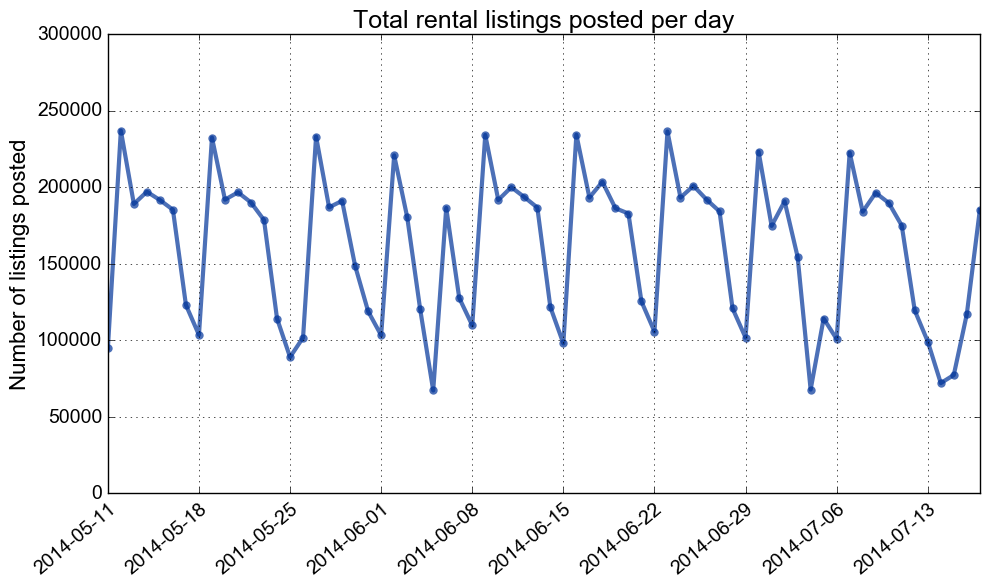

In [27]:
# plot the total number of listings (includes dupes/re-posts) posted on each day in the data set
ax = listings_per_date.plot(kind='line', figsize=[10, 6], ylim=[0,300000], linewidth=3, 
                            marker='o', markeredgewidth=0, alpha=0.7, color='#003399')
ax.grid(True)
ax.set_title('Total rental listings posted per day', fontproperties=title_font)
ax.set_ylabel('Number of listings posted', fontproperties=label_font)
ax.legend_.remove()

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=40, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

save_fig(plt.gcf(), 'date_count_listings_posted.png')
plt.show()

This data set covers mid May through mid July, 2014. The x-axis labels represent Sundays.

In [28]:
# calculate day of the week each listing was posted
all_listings['day_of_week'] = all_listings['date'].apply(lambda x: x.weekday())

## Next, de-duplicate the data set based on the 'pid' column and examine the unique vs duplicate listings

In [29]:
# first extract the subdomain/region from the link column
all_listings['region'] = all_listings['link'].str.extract('http://(.*).craigslist.org', expand=False)

In [30]:
# de-dupe data set and create a new dataframe to hold the unique listings
unique_listings = pd.DataFrame(all_listings.drop_duplicates(subset='pid', inplace=False))
len(unique_listings)

5480435

In [31]:
# create a view of the duplicate listings
duplicate_listings = all_listings[~all_listings.index.isin(unique_listings.index)]
len(duplicate_listings)

5477937

In [32]:
# show the top 5 PIDs with the most duplicates
most_dupe_pids = duplicate_listings['pid'].value_counts()
most_dupe_pids.head()

4516370259    15
4512724021    15
4509430137    15
4516426844    15
4512994294    15
Name: pid, dtype: int64

In [33]:
# examine the listings for the PID with the most duplicates - it is in brooklyn
cols = ['region', 'pid', 'neighborhood', 'rent', 'bedrooms', 'date']
all_listings[all_listings['pid']==most_dupe_pids.index[0]][cols]

,region,pid,neighborhood,rent,bedrooms,date
5100940,athensga,4516370259,30501,NaN,NaN,2014-06-11
5302183,athensga,4516370259,30501,NaN,NaN,2014-06-12
5657741,athensga,4516370259,30501,NaN,NaN,2014-06-14
5912910,athensga,4516370259,30501,NaN,NaN,2014-06-16
6332500,athensga,4516370259,30501,NaN,NaN,2014-06-18
6714823,athensga,4516370259,30501,NaN,NaN,2014-06-20
6994105,athensga,4516370259,30501,NaN,NaN,2014-06-22
7364083,athensga,4516370259,30501,NaN,NaN,2014-06-24
7757385,athensga,4516370259,30501,NaN,NaN,2014-06-26
8114021,athensga,4516370259,30501,NaN,NaN,2014-06-28


It looks like the listing's creator is re-publishing it every couple of days. This seems to maintain the same pid.

In [34]:
# calculate the ratios of unique to duplicate listings for each region
listings_ratios = pd.DataFrame()

# number of total listings for each region
listings_ratios['all_listings'] = all_listings['region'].value_counts()

# number of duplicate listings for each region (ie, listings that share a pid with at least one other listing)
listings_ratios['duplicate_listings'] = duplicate_listings['region'].value_counts()

# number of unique listings for the region (ie, none share a pid with another listing)
listings_ratios['unique_listings'] = unique_listings['region'].value_counts()

# percent of this region's listings that are duplicates
listings_ratios['duplicate_ratio'] = listings_ratios['duplicate_listings'] / listings_ratios['all_listings']

# percent of this region's listings that are unique (ie, not duplicates)
listings_ratios['unique_ratio'] = listings_ratios['unique_listings'] / listings_ratios['all_listings']

listings_ratios.head()

,all_listings,duplicate_listings,unique_listings,duplicate_ratio,unique_ratio
boston,1667785,1036662.0,631123,0.621580,0.378420
chicago,781426,458693.0,322733,0.586995,0.413005
newyork,622288,240911.0,381377,0.387137,0.612863
miami,529376,323408.0,205968,0.610923,0.389077
losangeles,380324,153775.0,226549,0.404326,0.595674


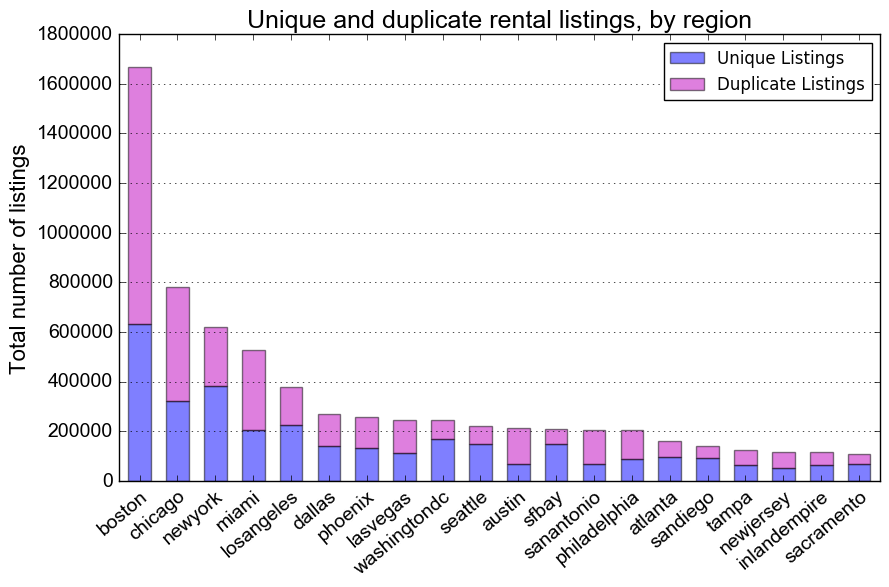

In [35]:
# plot the ratios of unique and duplicate listings, by region
countdata = listings_ratios.sort_values(by='all_listings', ascending=False)[['unique_listings', 'duplicate_listings']].head(20)
countdata.columns = ['Unique Listings', 'Duplicate Listings']
ax = countdata.plot(kind='bar',
                    stacked=True,
                    figsize=[9, 6], 
                    width=0.6, 
                    alpha=0.5, 
                    color=['b','m'],
                    edgecolor='k',
                    grid=False)

ax.yaxis.grid(True)
ax.set_xticks(range(0, len(countdata)))
ax.set_xticklabels(countdata.index, rotation=40, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
ax.set_title('Unique and duplicate rental listings, by region', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Total number of listings', fontproperties=label_font)        

save_fig(plt.gcf(), 'count_unique_duplicate_listings.png')
plt.show()

In [36]:
# which regions have the largest ratio of duplicate listings
listings_ratios = listings_ratios.sort_values(by='unique_ratio')
listings_ratios.head(10)

,all_listings,duplicate_listings,unique_listings,duplicate_ratio,unique_ratio
austin,213385,146295.0,67090,0.685592,0.314408
sanantonio,207356,140537.0,66819,0.677757,0.322243
merced,7160,4749.0,2411,0.663268,0.336732
springfield,30215,19734.0,10481,0.653119,0.346881
lincoln,13559,8753.0,4806,0.645549,0.354451
iowacity,9332,5973.0,3359,0.640056,0.359944
chambana,14749,9289.0,5460,0.629805,0.370195
galveston,4786,3014.0,1772,0.629753,0.370247
boston,1667785,1036662.0,631123,0.621580,0.378420
redding,7236,4489.0,2747,0.620370,0.379630


## Next, filter the data set by retaining only those rows that contain rent and sqft data

In [37]:
# thorough listings are unique listings with rent and sqft data
thorough_listings = pd.DataFrame(unique_listings)
thorough_listings = thorough_listings[thorough_listings['rent'] > 0]
thorough_listings = thorough_listings[thorough_listings['sqft'] > 0]

In [38]:
# for comparison, what are the counts of the differents sets?
print('Count of all listings:', len(all_listings))
print('Count of unique listings:', len(unique_listings))
print('Count of thorough listings:', len(thorough_listings))

Count of all listings: 10958372
Count of unique listings: 5480435
Count of thorough listings: 2971362


All listings are everything we collected. 

Unique listings are those with a unique pid (ie, re-posts are not counted). 

Thorough listings are unique listings with rent and sq foot data.

In [39]:
# what is the median rent per sqft across the set of thorough listings
thorough_listings['rent_sqft'].median()

1.1065573770491803

In [40]:
# for comparison, the median rent/sqft for the entire, original data set is very similar
all_listings['rent_sqft'].median()

1.0861423220973783

In [41]:
# describe the rent-per-sqft vector
thorough_listings['rent_sqft'].describe()

count    2.971362e+06
mean     9.891925e+01
std      1.250851e+05
min      1.000001e-06
25%      8.214286e-01
50%      1.106557e+00
75%      1.709160e+00
max      2.147484e+08
Name: rent_sqft, dtype: float64

You can see the mean is pulled up by ridiculous high outliers (like $214 million per sq ft). There are also some ridiculous low outliers. So, let's filter out outliers that fall outside of a reasonable range.

## Filter data set, retaining listings that have reasonable values for rent, sqft, and rent/sqft
Define reasonable by the 0.2 and 99.8 percentiles for rent, sqft, and rent/sqft.

In [42]:
# in this cell, define the values by which we will filter the 3 columns
upper_percentile = 0.998
lower_percentile = 0.002

# how many rows would be within the upper and lower percentiles?
upper = int(len(thorough_listings) * upper_percentile)
lower = int(len(thorough_listings) * lower_percentile)

# get the rent/sqft values at the upper and lower percentiles
rent_sqft_sorted = thorough_listings['rent_sqft'].sort_values(ascending=True, inplace=False)
upper_rent_sqft = rent_sqft_sorted.iloc[upper]
lower_rent_sqft = rent_sqft_sorted.iloc[lower]

# get the rent values at the upper and lower percentiles
rent_sorted = thorough_listings['rent'].sort_values(ascending=True, inplace=False)
upper_rent = rent_sorted.iloc[upper]
lower_rent = rent_sorted.iloc[lower]

# get the sqft values at the upper and lower percentiles
sqft_sorted = thorough_listings['sqft'].sort_values(ascending=True, inplace=False)
upper_sqft = sqft_sorted.iloc[upper]
lower_sqft = sqft_sorted.iloc[lower]

print('valid rent_sqft range:', [lower_rent_sqft, upper_rent_sqft])
print('valid rent range:', [lower_rent, upper_rent])
print('valid sqft range:', [lower_sqft, upper_sqft])

valid rent_sqft range: [0.10000000000000001, 12.626262626262626]
valid rent range: [189.0, 10287.0]
valid sqft range: [220.0, 5200.0]


In [43]:
# create a boolean vector mask to filter out any rows with rent_sqft outside of the reasonable values
rent_sqft_mask = (thorough_listings['rent_sqft'] > lower_rent_sqft) & (thorough_listings['rent_sqft'] < upper_rent_sqft)

# create boolean vector masks to filter out any rows with rent or sqft outside of the reasonable values
rent_mask = (thorough_listings['rent'] > lower_rent) & (thorough_listings['rent'] < upper_rent)
sqft_mask = (thorough_listings['sqft'] > lower_sqft) & (thorough_listings['sqft'] < upper_sqft)

# filter the thorough listings according to these masks
filtered_listings = pd.DataFrame(thorough_listings[rent_sqft_mask & rent_mask & sqft_mask])
len(filtered_listings)

2947761

In [44]:
# how many 'unreasonable' listings did we filter out?
count_removed = len(thorough_listings) - len(filtered_listings)
print(count_removed)
print(count_removed / float(len(thorough_listings)))

23601
0.007942822180535391


In [46]:
# save three regional subsets for tract-level analysis
filtered_listings[filtered_listings['region']=='sfbay'].to_csv('sfbay-filtered-listings.csv', index=False, encoding='utf-8')
filtered_listings[filtered_listings['region']=='seattle'].to_csv('seattle-filtered-listings.csv', index=False, encoding='utf-8')
filtered_listings[filtered_listings['region']=='newyork'].to_csv('newyork-filtered-listings.csv', index=False, encoding='utf-8')

So, we filtered out 23,601 or 0.79% of the thorough listings. Although we discarded values below the 0.2% and the 99.8%, we did it on three separate variables (rent, sqft, rent/sqft) so the total number of rows discarded was higher than 0.4%.

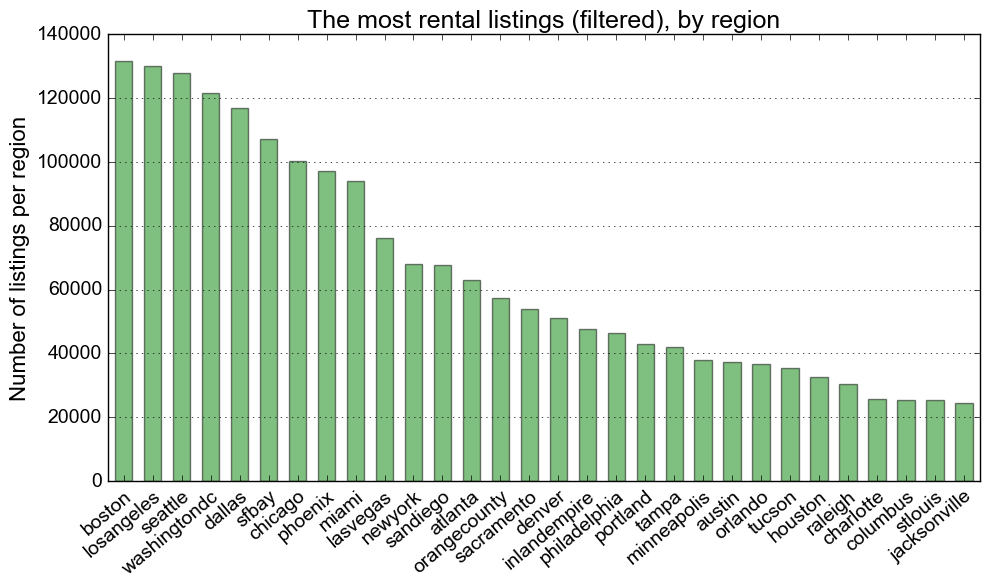

In [47]:
# plot the number of filtered rental listings by region
countdata = filtered_listings['region'].value_counts().head(30)
ax = countdata.plot(kind='bar',                 
                    figsize=[10, 6], 
                    width=0.6, 
                    alpha=0.5, 
                    color='g',
                    edgecolor='k',
                    grid=False)

ax.yaxis.grid(True)
ax.set_xticks(range(0, len(countdata)))
ax.set_xticklabels(countdata.index, rotation=40, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
ax.set_title('The most rental listings (filtered), by region', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Number of listings per region', fontproperties=label_font)

save_fig(plt.gcf(), 'count_most_listings_filtered.png')
plt.show()

## Let's look at a couple of measures of statistical dispersion to see how the thorough listings differ from this filtered set of reasonable listings

In [48]:
# calculate the interquartile range of the thorough listings
print(thorough_listings['rent_sqft'].describe()['75%'] - thorough_listings['rent_sqft'].describe()['25%'])

# calculate the interquartile range of the filtered listings
print(filtered_listings['rent_sqft'].describe()['75%'] - filtered_listings['rent_sqft'].describe()['25%'])

0.887731013085
0.879204073429


The interquartile ranges are very similar for each -- filtering didn't change this measure of statistical dispersion much

In [49]:
# calculate the std deviation of the thorough listings
print(thorough_listings['rent_sqft'].std())

# calculate the std deviation of the filtered listings
print(filtered_listings['rent_sqft'].std())

125085.11424020329
0.8570999442710893


The standard deviation dropped drastically from 125,085.11 to 0.86 after filtering out just 0.79% of the thorough listings that were the greatest outliers.

In [50]:
# look at how descriptive stats changed after filtering by reasonable values
cols = ['rent','sqft','rent_sqft']
c = thorough_listings[cols].describe().rename(columns={'rent':'rent1','sqft':'sqft1','rent_sqft':'rent_sqft1'})
f = filtered_listings[cols].describe().rename(columns={'rent':'rent2','sqft':'sqft2','rent_sqft':'rent_sqft2'})
cf = pd.concat(objs=[c,f], axis=1)
cf = cf.reindex(columns=['rent1','rent2','sqft1','sqft2','rent_sqft1','rent_sqft2'])
cf

,rent1,rent2,sqft1,sqft2,rent_sqft1,rent_sqft2
count,2.971362e+06,2.947761e+06,2.971362e+06,2.947761e+06,2.971362e+06,2.947761e+06
mean,1.099428e+04,1.381766e+03,1.182688e+03,1.084518e+03,9.891925e+01,1.389771e+00
std,3.090407e+06,8.709270e+02,1.958283e+04,5.125596e+02,1.250851e+05,8.570999e-01
min,1.000000e+00,1.900000e+02,1.000000e+00,2.210000e+02,1.000001e-06,1.004464e-01
25%,8.000000e+02,8.000000e+02,7.550000e+02,7.570000e+02,8.214286e-01,8.235294e-01
50%,1.145000e+03,1.145000e+03,9.820000e+02,9.820000e+02,1.106557e+00,1.106428e+00
75%,1.695000e+03,1.695000e+03,1.234000e+03,1.230000e+03,1.709160e+00,1.702733e+00
max,2.147484e+09,1.028500e+04,8.388607e+06,5.197000e+03,2.147484e+08,1.260504e+01


Above you can see how the descriptive stats changed in each field from before (the 1s) to after (the 2s) we filtered by reasonable values.

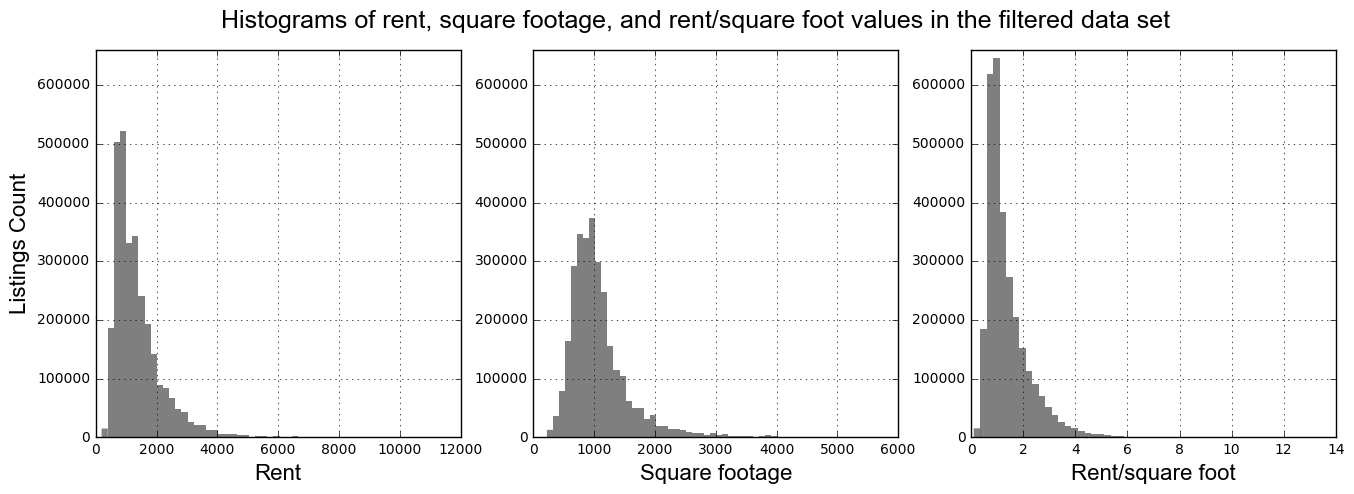

In [51]:
# plot histograms of rent, sqft, and rent/sqft values in the filtered data set
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[16, 5])
bins = 50
color = 'k'
edgecolor = 'None'
alpha = 0.5
ylim = [0, 660000]

# histogram of rents
ax0 = filtered_listings['rent'].hist(ax=axes[0], bins=bins, color=color, edgecolor=edgecolor, alpha=alpha)
ax0.set_ylim(ylim)
ax0.set_xlabel('Rent', fontproperties=label_font)
ax0.set_ylabel('Listings Count', fontproperties=label_font)

# histogram of sqft
ax1 = filtered_listings['sqft'].hist(ax=axes[1], bins=bins, color=color, edgecolor=edgecolor, alpha=alpha)
ax1.set_ylim(ylim)
ax1.set_xlabel('Square footage', fontproperties=label_font)

# histogram of rent/sqft
ax2 = filtered_listings['rent_sqft'].hist(ax=axes[2], bins=bins, color=color, edgecolor=edgecolor, alpha=alpha)
ax2.set_ylim(ylim)
ax2.set_xlabel('Rent/square foot', fontproperties=label_font)

fig.suptitle('Histograms of rent, square footage, and rent/square foot values in the filtered data set', 
             fontproperties=title_font)

save_fig(plt.gcf(), 'hist_rent_sqft_rentpersqft.png', tight=False)
plt.show()

These histograms show the distribution of these values across the filtered data set. Now plot continuous distributions of rent/sqft use KDE.

In [52]:
# first, sort the 15 most populous metros by median rent/sqft
median_rent_sqft_by_region = filtered_listings.groupby('region')['rent_sqft'].median()
median_rent_sqft_populous_regions = median_rent_sqft_by_region[most_populous_regions.index].sort_values(ascending=False, 
                                                                                                        inplace=False)
metro_names = list(median_rent_sqft_populous_regions.index)

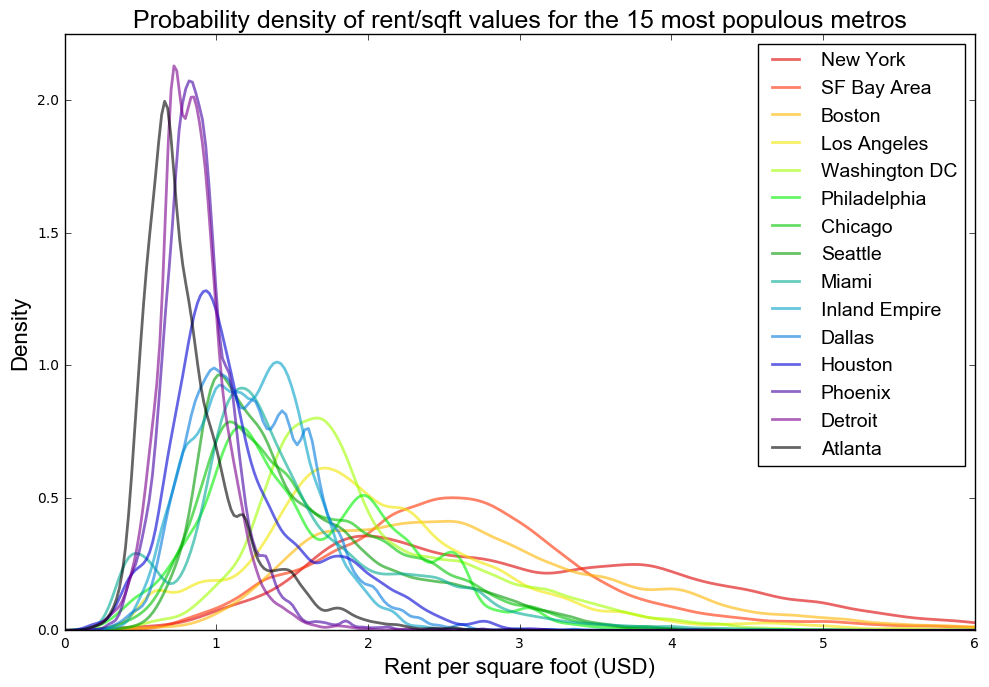

In [53]:
# get a different color for each of the lines to plot
color_list = get_colors('spectral', len(metro_names), start=0, stop=0.9, reverse=True)
#color_list = get_colors('plasma', len(metro_names), start=0.15, stop=0.85, reverse=False)
#color_list = get_colors('viridis', len(metro_names), start=0, stop=0.9, reverse=False)

for name, color in zip(metro_names, color_list):
    values = filtered_listings[filtered_listings['region']==name]['rent_sqft']
    ax = values.plot(kind='kde', color=color, linewidth=2, alpha=0.6, figsize=[10, 7])
    
ax.grid(False)
ax.set_xlim([0,6])
ax.set_ylim([0,2.25])
ax.set_xlabel('Rent per square foot (USD)', fontproperties=label_font)
ax.set_ylabel('Density', fontproperties=label_font)
ax.set_title('Probability density of rent/sqft values for the 15 most populous metros', fontproperties=title_font)
ax.legend([regions_full_names[x] for x in metro_names], prop=ticks_font)

save_fig(plt.gcf(), 'kde_most_populous_metros.png')
plt.show()

Probability densities can exceed 1 because the function is defined over a continuous interval. Probabilities are measured over intervals rather than at single points, so the area beneath the curve between any two points represents the probability for that interval. The integral of the function (the total area under the curve) must equal 1, similar to how the sum of all probabilities in a discrete distribution must equal 1.

There are 415 regions in the entire data set. Let's see the KDEs for all 415 of them.

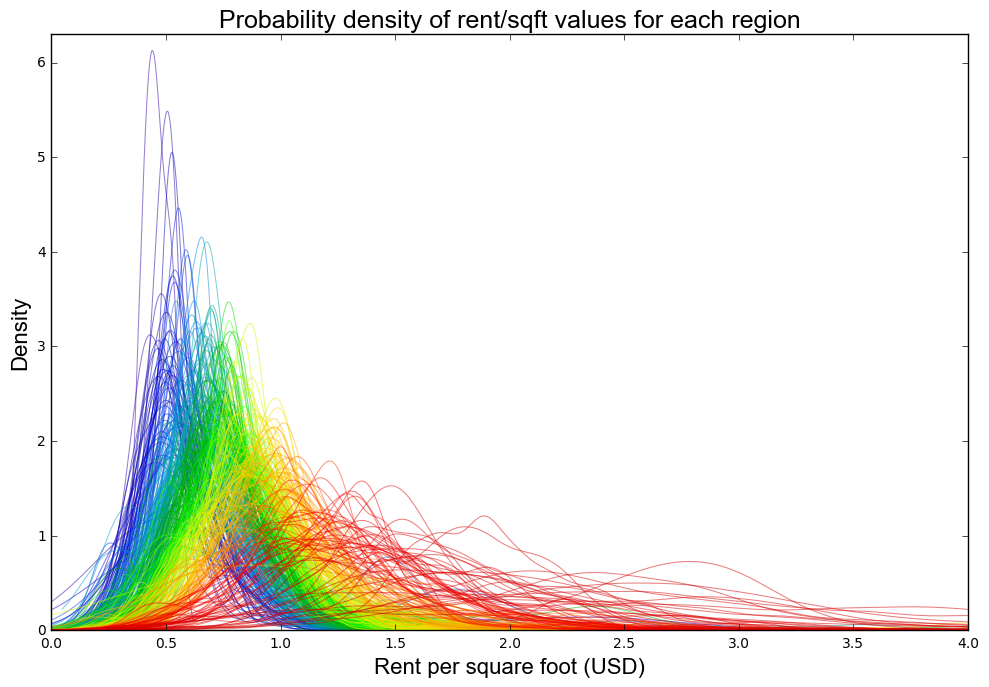

In [54]:
# first, sort all regions ascending by median rent/sqft to print high values last (ie, on top of the other lines)
region_names = list(median_rent_sqft_by_region.sort_values(ascending=True, inplace=False).index)

# get one color from red through blue (don't use violets/grays) for each line/region
color_list = get_colors('spectral', len(region_names), start=0.13, stop=0.93)
#color_list = get_colors('viridis', len(region_names), start=0, stop=0.9, reverse=True)

for name, color in zip(region_names, color_list):
    values = filtered_listings[filtered_listings['region']==name]['rent_sqft']
    ax = values.plot(kind='kde', color=color, linewidth=.75, alpha=0.5, figsize=[10, 7])
    
ax.grid(False)
ax.set_xlim([0, 4])
ax.set_ylim([0, 6.3])
ax.set_xlabel('Rent per square foot (USD)', fontproperties=label_font)
ax.set_ylabel('Density', fontproperties=label_font)
ax.set_title('Probability density of rent/sqft values for each region', fontproperties=title_font)

save_fig(plt.gcf(), 'kde_all_regions.png')
plt.show()

This is the KDE of rent/sqft for every region in the filtered data set. Each region has its own line, colored by median rent/sqft for that region (high=red, low=blue/violet)

## Analyze the most and least expensive regions in the filtered data set, by price/sqft

In [55]:
# create a categorical variable by dividing the data set into quantiles
num_bins = 5
bin_labels = [ str(n + 1) for n in range(num_bins) ]
quantiles = pd.qcut(x=filtered_listings['rent_sqft'], q=num_bins, labels=bin_labels)
filtered_listings['rent_sqft_cat'] = quantiles

In [56]:
# grab the most and least expensive regions, by median rent per sq ft
most_expensive = median_rent_sqft_by_region.sort_values(ascending=False, inplace=False)
least_expensive = median_rent_sqft_by_region.sort_values(ascending=True, inplace=False)

In [57]:
filtered_median_rent_sqft = filtered_listings['rent_sqft'].median()

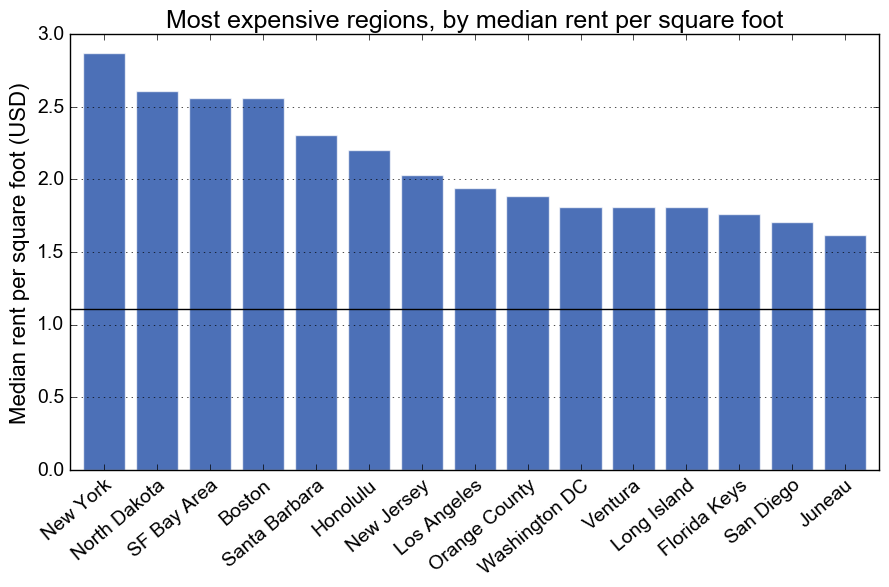

In [58]:
# plot the most expensive regions
countdata = most_expensive.head(15)
countdata = countdata.rename({'nd':'northdakota', 'keys':'floridakeys'})
xlabels = [regions_full_names[x] for x in countdata.index]
ax = countdata.plot(kind='bar',                 
                    figsize=[9, 6], 
                    width=0.8, 
                    alpha=0.7, 
                    color='#003399',
                    edgecolor='w',
                    grid=False)

ax.yaxis.grid(True)
ax.set_xticks(range(0, len(countdata)))
ax.set_xticklabels(xlabels, rotation=40, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
ax.set_title('Most expensive regions, by median rent per square foot', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Median rent per square foot (USD)', fontproperties=label_font)

# draw a line showing the median rent/sqft in the filtered data set
plt.plot([-1, 60], [filtered_median_rent_sqft, filtered_median_rent_sqft], 'k-', color='k', alpha=1, linewidth=1)

save_fig(plt.gcf(), 'median_rent_sqft_most_expensive_regions.png')
plt.show()

The horizontal line depicts the median rent/sqt across the entire filtered data set.

In [59]:
# the least expensive regions are very small
least_expensive.head(10)

region
csd           0.449495
albanyga      0.468677
meadville     0.500000
swks          0.500000
wv            0.500000
eastky        0.500000
kirksville    0.500000
swv           0.500000
fortdodge     0.500000
owensboro     0.500000
Name: rent_sqft, dtype: float64

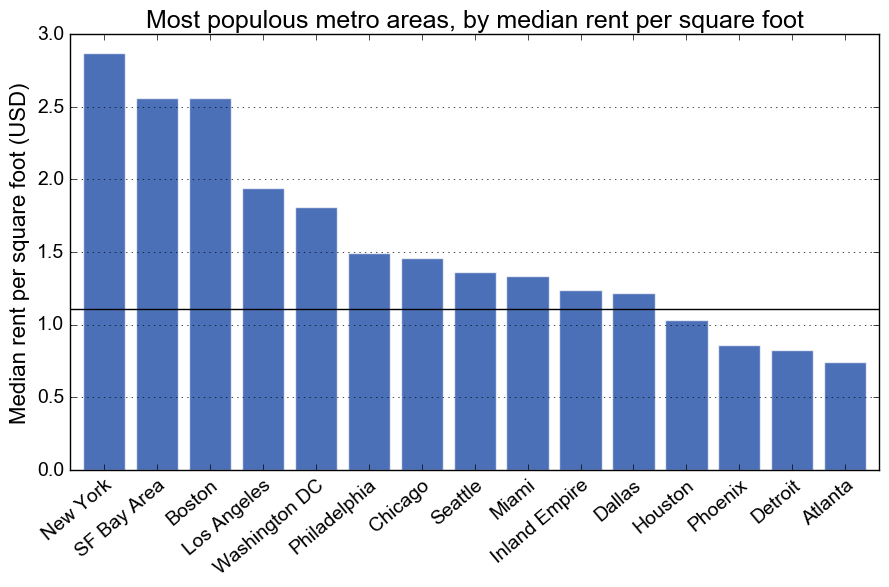

In [60]:
# plot the rent per sq ft for the 15 most populous metros in the U.S.
countdata = median_rent_sqft_populous_regions
xlabels = [regions_full_names[x] for x in countdata.index]
ax = countdata.plot(kind='bar',                 
                    figsize=[9, 6], 
                    width=0.8, 
                    alpha=0.7, 
                    color='#003399',
                    edgecolor='w',
                    grid=False)

ax.yaxis.grid(True)
ax.set_xticks(range(0, len(countdata)))
ax.set_xticklabels(xlabels, rotation=40, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
ax.set_title('Most populous metro areas, by median rent per square foot', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Median rent per square foot (USD)', fontproperties=label_font)

# draw a line showing the median rent/sqft in the filtered data set
plt.plot([-1, 60], [filtered_median_rent_sqft, filtered_median_rent_sqft], 'k-', color='k', alpha=1, linewidth=1)

save_fig(plt.gcf(), 'median_rent_sqft_populous_metros.png')
plt.show()

## Get summary data for regions and analyze affordability

Compare to 2014 American Community Survey 1-Year Estimates of Median household income in the past 12 months (in 2014 inflation-adjusted dollars) (B19013) to assess the rent burden, and to Annual Estimates of the Resident Population 2014 population estimates (as of July 1).

In [62]:
# get the regions that appear in the census data file we loaded at the beginning
# rename orangecounty to losangeles to combine into one to match census metro area
fl_regions = pd.DataFrame(filtered_listings)
fl_regions['region_census'] = fl_regions['region'].map(lambda x: x if not x=='orangecounty' else 'losangeles')
fl_regions = fl_regions[filtered_listings['region_census'].isin(census.index)]

print(len(fl_regions['region_census'].value_counts()))
print(len(fl_regions))
print(len(fl_regions) / float(len(filtered_listings)))

58
2297566
0.7794275044686458


There are 58 regions in the census data file (out of 415 total in the filtered data set, or 14%), comprising a sample size of 2,297,566 rental listings, or 77.9% of the filtered data set. Also, the fl_regions dataframe combines the losangeles and orangecounty regions into one.

In [65]:
# what is the nationwide median rent and sq ft?
nationwide_median_rent = filtered_listings['rent'].median()
print(nationwide_median_rent)

nationwide_median_sqft = filtered_listings['sqft'].median()
print(nationwide_median_sqft)

1145.0
982.0


In [66]:
# calculate some stats on affordability and region summaries
regions = census
regions['count_listings'] = fl_regions.groupby('region_census').size().astype(int)
regions['median_rent'] = fl_regions.groupby('region_census')['rent'].median().astype(int)
regions['median_sqft'] = fl_regions.groupby('region_census')['sqft'].median().astype(int)
regions['median_rent_sqft'] = fl_regions.groupby('region_census')['rent_sqft'].median().round(2)
regions['rent_proportion'] = (regions['median_rent'] / (regions['2014_median_income'] / 12)).round(2)
regions['rental_power'] = (nationwide_median_rent / regions['median_rent_sqft']).astype(int)

In [68]:
# save to csv and display the head
regions = regions.sort_values(by='2014_pop_est', ascending=False, inplace=False)
regions.to_csv('data/regions_census_summary.csv', index=True)
regions.head()[['2014_median_income','2014_pop_est','count_listings','median_rent','median_sqft',
                'median_rent_sqft','rent_proportion','rental_power']]

,2014_median_income,2014_pop_est,count_listings,median_rent,median_sqft,median_rent_sqft,rent_proportion,rental_power
region,,,,,,,,
newyork,67066,20092883,68029,2500,900,2.87,0.45,398
losangeles,60514,13262220,187626,1760,950,1.91,0.35,599
chicago,61598,9554598,100184,1500,1000,1.46,0.29,784
sfbay,80600,8607423,107087,2323,910,2.56,0.35,447
dallas,59530,6954330,116856,1100,953,1.22,0.22,938


2014 median income is from the 2014 American Community Survey’s 1-year estimates of median household income (in 2014 inflation-adjusted dollars). 2014 population estimates are from the American Community Survey’s 2014 annual estimates of resident population (as of July 1). Median rent, sqft, and rent/sqft are calculated from the filtered data set (note: median rent/sqft is not equivalent to median rent/median sqft). The rent proportion is the ratio of median rent to median monthly household income. Sqft rental power is an estimate of how many square feet can be rented in each region for the nationwide median rent, and is calculated by dividing nationwide median rent by regional median rent per sqft.

count_listings vs 2014_pop_est
r=0.669, p=0.000


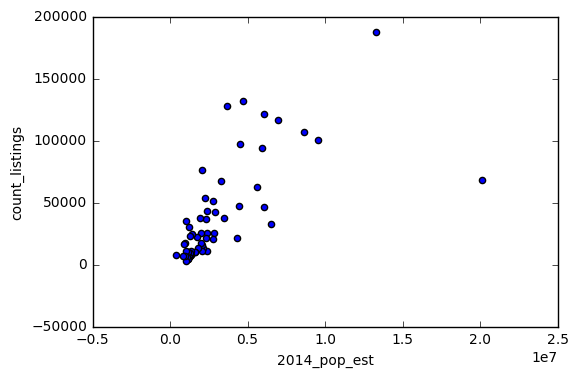

count_listings vs 2014_median_income
r=0.486, p=0.000


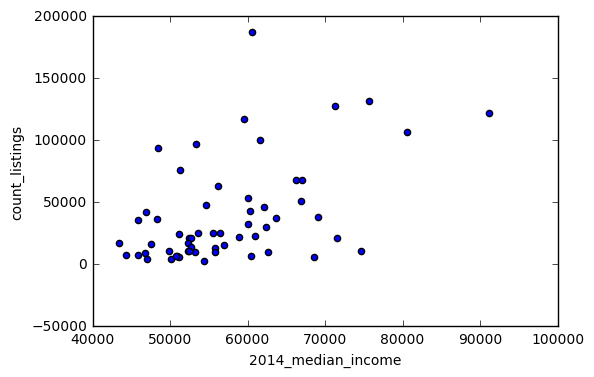

median_rent_sqft vs count_listings
r=0.595, p=0.000


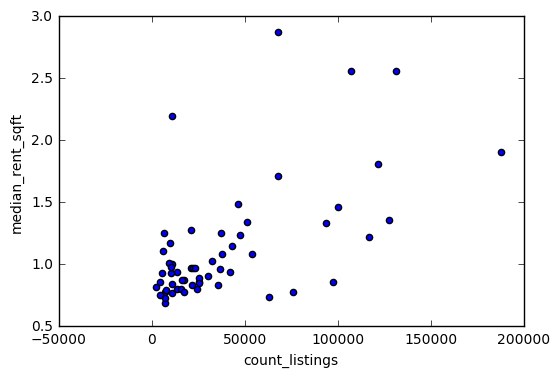

median_rent_sqft vs 2014_median_income
r=0.721, p=0.000


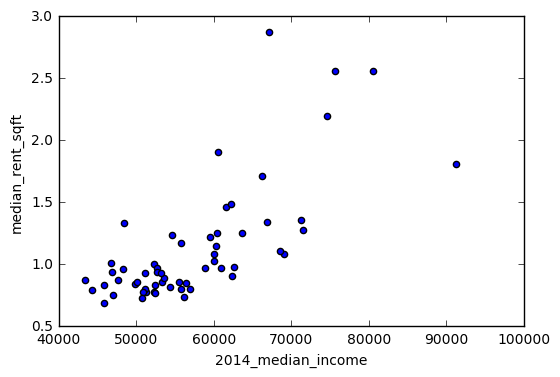

In [70]:
# look at some simple correlations between these variables
xs = ['2014_pop_est', '2014_median_income', 'count_listings', '2014_median_income']
ys = ['count_listings', 'count_listings', 'median_rent_sqft', 'median_rent_sqft']
for x, y in zip(xs, ys):
    print('{} vs {}'.format(y, x))
    r, p = pearsonr(regions[x], regions[y])
    print('r={:0.3f}, p={:0.3f}'.format(r, p))
    regions.plot(kind='scatter', x=x, y=y)
    plt.show()

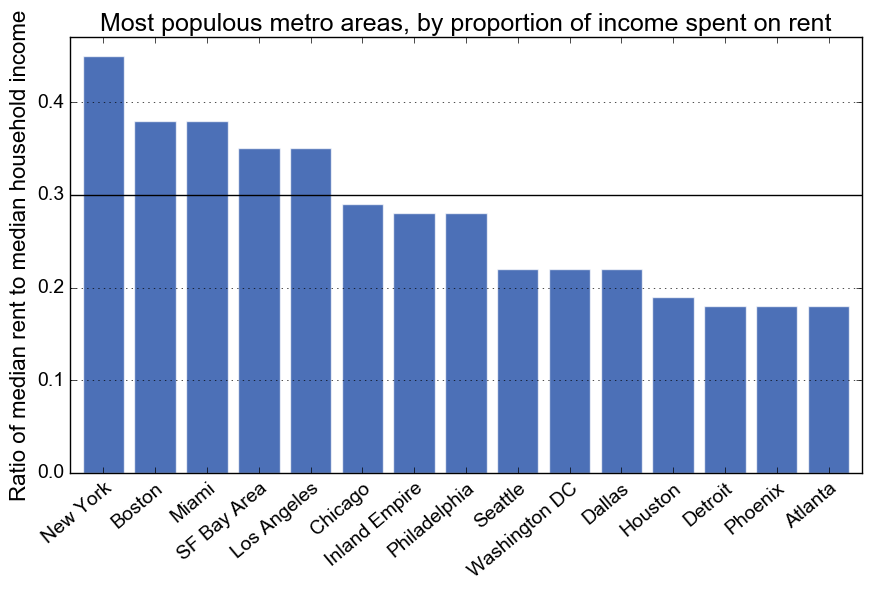

In [71]:
# plot the rent burden for the 15 most populous metros in the U.S.
countdata = regions['rent_proportion'][most_populous_regions.index].sort_values(ascending=False, inplace=False)
xlabels = [regions_full_names[x] for x in countdata.index]
ax = countdata.plot(kind='bar',                 
                    figsize=[9, 6], 
                    width=0.8, 
                    alpha=0.7, 
                    color='#003399',
                    edgecolor='w',
                    ylim=[0, 0.47],
                    grid=False)

ax.yaxis.grid(True)
ax.set_xticks(range(0, len(countdata)))
ax.set_xticklabels(xlabels, rotation=40, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
ax.set_title('Most populous metro areas, by proportion of income spent on rent', fontproperties=title_font)
ax.set_xlabel('')
ax.set_ylabel('Ratio of median rent to median household income', fontproperties=label_font)

# draw a line showing the rent burden
plt.plot([-1, 60], [0.3, 0.3], 'k-', color='k', alpha=1, linewidth=1)

save_fig(plt.gcf(), 'rent_proportion.png')
plt.show()

0.3 is the common threshold for rent burden. Here we can see 5 of the 15 most populous regions' median rents exceed 30% of the metro areas' median monthly household income.

Based on each region's median rent/sqft, how many square feet can you rent in each of the 15 most populous metro areas for the nationwide median rent of $1,145?

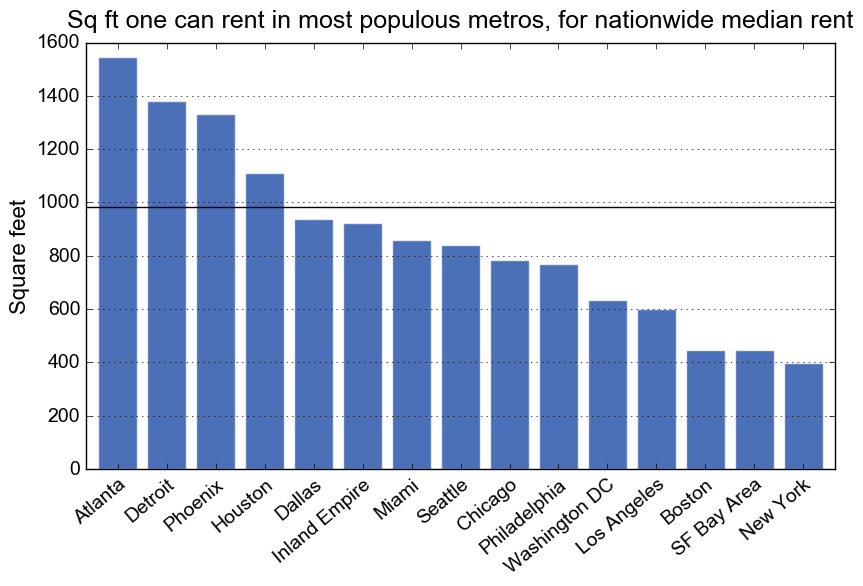

In [72]:
# plot the sqft you can buy for the nationwide median rent for the 15 most populous metros in the U.S.
countdata = countdata = regions['rental_power'][most_populous_regions.index].sort_values(ascending=False, inplace=False)
xlabels = [regions_full_names[x] for x in countdata.index]
ax = countdata.plot(kind='bar',                 
                    figsize=[9, 6], 
                    width=0.8, 
                    alpha=0.7, 
                    color='#003399',
                    edgecolor='w',
                    grid=False)

ax.yaxis.grid(True)
ax.set_xticks(range(0, len(countdata)))
ax.set_xticklabels(xlabels, rotation=40, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
ax.set_title('Sq ft one can rent in most populous metros, for nationwide median rent', y=1.02, fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Square feet', fontproperties=label_font)

# draw a line showing the nationwide median sqft
plt.plot([-1, 16], [nationwide_median_sqft, nationwide_median_sqft], 'k-', color='k', alpha=1, linewidth=1)

save_fig(plt.gcf(), 'rental_power.png')
plt.show()

The horizontal line depicts the nationwide median square footage in the filtered data set.

## Compare rental listings by regions and # bedrooms to HUD fair market rents

Determine the ratio of listings below the fair market rent, as defined by HUD. FMRs generally correspond to 40th percentile rents and FMR areas generally correspond to metropolitan areas, but inconsistently so as HUD uses a more complicated formula to determine percentiles and area boundaries in different circumstances. Dallas is excluded here as the Dallas metro FMR area uses only disaggregate "Small Area FMRs" as defined by ZIP codes.

In [75]:
# load the HUD 2014 median rents and fair market rents data (per region and per # of bedrooms)
hud = pd.read_csv('data/hud_frm_median_rent_metro_bedrooms.csv', index_col='region', encoding='ISO-8859-1')

In [76]:
# get all the filtered listings for our regions, that have 1-4 bedrooms
reg_rent = filtered_listings[filtered_listings['region'].isin(hud.index)][['region', 'bedrooms', 'rent']]
reg_rent.index = [reg_rent['region'], reg_rent['bedrooms']]
reg_rent = reg_rent[reg_rent['bedrooms'].isin([1,2,3,4])]
reg_rent.sort_index(inplace=True) #sort index for faster performance

In [77]:
# assign the fair market rent value (determined by region and # of bedrooms) to each row in the dataframe
reg_rent['fmr'] = None
for name in hud.index:
    for br in [1,2,3,4]:
        reg_rent.loc[(name, br), 'fmr'] = hud.loc[name, 'FMR_{0}'.format(br)]

In [78]:
# what is the ratio of listings below FMR to total listings, in the entire filtered data set
reg_rent['below_fmr'] = reg_rent['rent'] <= reg_rent['fmr']
reg_rent_vc = reg_rent['below_fmr'].value_counts()
fmr_ratio = reg_rent_vc[True] / float(reg_rent_vc.sum())
fmr_ratio

0.37009499574288968

37% of the listings in the filtered data set are at/below fair market rent for that region and number of bedrooms.

In [79]:
# break out the proportion of listings below FMR, by bedrooms (agnostic to region)
reg_rent_below = reg_rent[reg_rent['below_fmr']]
below_FMR_br = reg_rent_below.groupby(['region', 'bedrooms']).count()['below_fmr'].unstack().sum()
total_br = reg_rent.groupby(['region', 'bedrooms']).count()['below_fmr'].unstack().sum()
fmr_ratio_by_br = below_FMR_br / total_br
fmr_ratio_by_br.index = [int(label) for label in fmr_ratio_by_br.index]
fmr_ratio_by_br.loc['all_1-4'] = fmr_ratio
fmr_ratio_by_br.name = 'total'
fmr_ratio_by_br

1          0.286384
2          0.362690
3          0.509748
4          0.450591
all_1-4    0.370095
Name: total, dtype: float64

Broken out by number of bedrooms, 29% of the 1 bedroom listings are below FMR, 36% of the 2 bedrooms, 51% of the 3 bedrooms, and 45% of the 4 bedrooms.

In [80]:
# break out the proportion of listings below FMR, by region
reg_rent_below = reg_rent[reg_rent['below_fmr']]
ratio_below_fmr = reg_rent_below.groupby('region').count()['below_fmr'] / reg_rent.groupby('region').count()['below_fmr']
ratio_below_fmr.name = 'all_1-4'

In [81]:
# break out the proportion of listings below FMR, by region and bedrooms
ratio_below_fmr_br = reg_rent_below.groupby(['region','bedrooms']).count()['below_fmr'] / reg_rent.groupby(['region','bedrooms']).count()['below_fmr']
ratio_below_fmr_br = ratio_below_fmr_br.unstack()
ratio_below_fmr_br.columns = [int(label) for label in ratio_below_fmr_br.columns]
ratio_below_fmr_br = pd.concat([ratio_below_fmr_br, ratio_below_fmr], axis=1)
ratio_below_fmr_br.head(6)

,1,2,3,4,all_1-4
region,,,,,
albuquerque,0.710481,0.584729,0.695796,0.622642,0.649520
atlanta,0.470503,0.623493,0.805586,0.739594,0.633021
austin,0.304154,0.303352,0.441073,0.454545,0.328899
baltimore,0.406883,0.497612,0.563785,0.414493,0.476723
bham,0.291965,0.253674,0.495993,0.414634,0.338038
boston,0.048058,0.071138,0.082925,0.050650,0.064463


The proportion of listings at/below the FMR varies considerably by region and by number of bedrooms.

In [82]:
# add the totals to the bottom of the dataframe, round it, and save to csv
ratio_below_fmr_br = ratio_below_fmr_br.append(fmr_ratio_by_br)
np.round(ratio_below_fmr_br, 2).to_csv('data/regions_fmr_summary.csv')

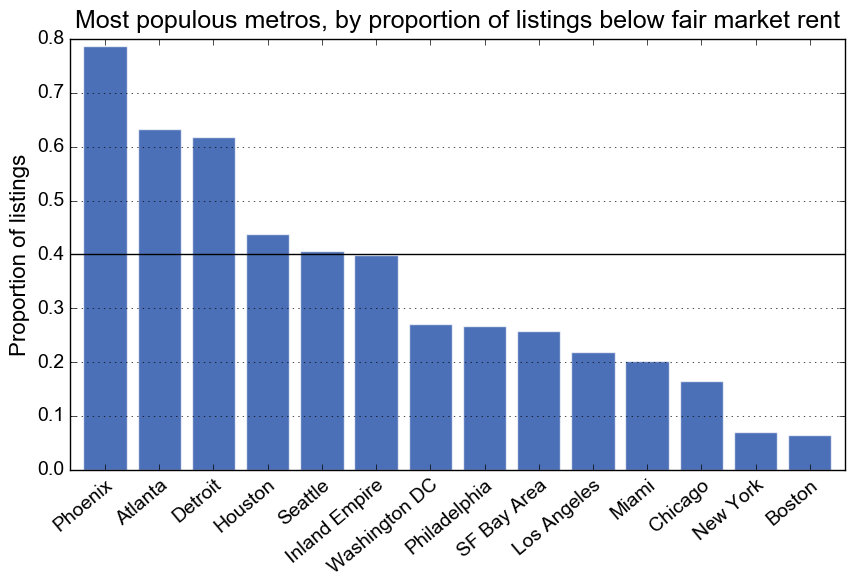

In [83]:
# plot the proportion of listings at/below FMR for the 15 most populous metros
countdata = ratio_below_fmr_br['all_1-4'][most_populous_regions.index].sort_values(ascending=False, inplace=False)
countdata = countdata.drop(labels='dallas', axis=0)
xlabels = [regions_full_names[x] for x in countdata.index]
ax = countdata.plot(kind='bar',                 
                    figsize=[9, 6], 
                    width=0.8, 
                    alpha=0.7, 
                    color='#003399',
                    edgecolor='w',
                    ylim=[0, 0.8],
                    grid=False)

ax.yaxis.grid(True)
ax.set_xticks(range(0, len(countdata)))
ax.set_xticklabels(xlabels, rotation=40, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
ax.set_title('Most populous metros, by proportion of listings below fair market rent', y=1.01, fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Proportion of listings', fontproperties=label_font)

# draw a line showing the rent burden
plt.plot([-1, 60], [0.4, 0.4], 'k-', color='k', alpha=1, linewidth=1)

save_fig(plt.gcf(), 'fmr_proportions.png')
plt.show()

The 14 most populous metro areas (i.e. the 15, sans Dallas, for whom there is no metro-level FMR data) by proportion of listings in the filtered data set at or below the HUD fair market rent value. The horizontal line marks the 40th percentile: for reference, HUD bases their FMRs on the 40th percentile rent.

While regions like Phoenix, Atlanta, and Detroit have greater than 60% of their listings below the fair market rent, New York and Boston have single digit percentages of listings below the fair market rent.

## Validate the data set against HUD median rents by region

In [84]:
# get median rent per metro per # of bedrooms (1-4)
mask = filtered_listings['region'].isin(regions.sort_index(inplace=False).index) & filtered_listings['bedrooms'].isin([1,2,3,4])
region_br_rent = filtered_listings[mask].groupby(['region', 'bedrooms'])['rent'].median().unstack()
region_br_rent.columns = ['clist_{0}'.format(br) for br in pd.Series(region_br_rent.columns).astype(int)]

region_br_rent.head()

,clist_1,clist_2,clist_3,clist_4
region,,,,
albuquerque,613.0,780.0,1050.0,1325.0
atlanta,780.0,820.0,899.0,1125.0
austin,933.0,1245.0,1525.0,1850.0
baltimore,1100.0,1258.5,1499.0,1950.0
bham,709.0,856.0,979.0,1125.0


In [85]:
# join the Craigslist median rents and the HUD median rents
region_hud = pd.concat([region_br_rent, hud], axis=1)

To assess the relationship between the Craigslist median rents and the HUD median rents (by region), first scatter plot them. HUD median rents are calculated for "fair market rent areas" that with a few exceptions generally correspond to OMB definitions of metropolitan areas, as these generally correspond well to housing market areas. However, these are median rent values, not FMRs here.

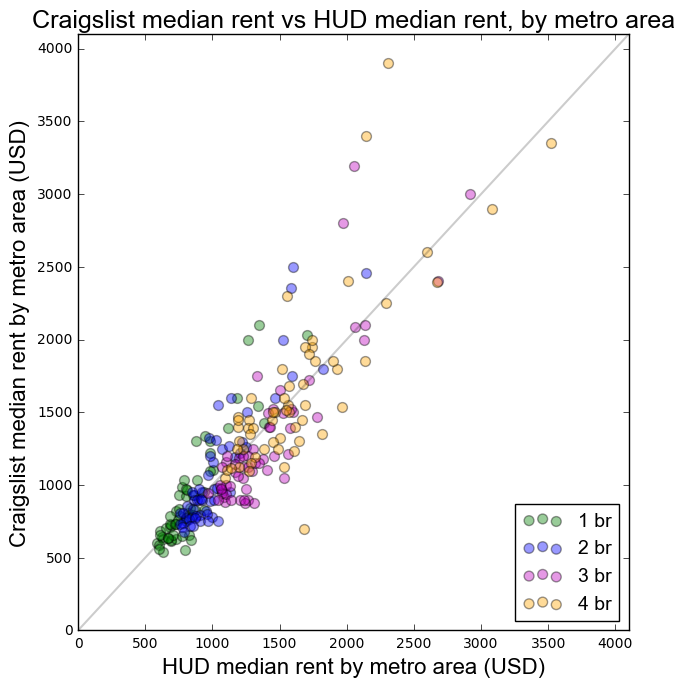

In [86]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)

labels = ['1 br', '2 br', '3 br', '4 br']
plots = []
plots.append(ax.scatter(x=region_hud['HUD_median_1'], y=region_hud['clist_1'], c='g', edgecolor='k', alpha=.4, s=50))
plots.append(ax.scatter(x=region_hud['HUD_median_2'], y=region_hud['clist_2'], c='b', edgecolor='k', alpha=.4, s=50))
plots.append(ax.scatter(x=region_hud['HUD_median_3'], y=region_hud['clist_3'], c='m', edgecolor='k', alpha=.4, s=50))
plots.append(ax.scatter(x=region_hud['HUD_median_4'], y=region_hud['clist_4'], c='orange', edgecolor='k', alpha=.4, s=50))

ax.set_xlim([0,4100])
ax.set_ylim([0,4100])

ax.set_title('Craigslist median rent vs HUD median rent, by metro area', fontproperties=title_font)
ax.set_xlabel('HUD median rent by metro area (USD)', fontproperties=label_font)
ax.set_ylabel('Craigslist median rent by metro area (USD)', fontproperties=label_font)
plt.legend(plots, labels, loc=4, prop=ticks_font)

# draw a line indicating a perfect linear relationship
plt.plot([0, 4100], [0, 4100], 'k-', color='k', alpha=0.2, linewidth=1.5)

save_fig(plt.gcf(), 'median_rent_hud_craigslist.png')
plt.show()

Points are above the line when Craigslist median rent is greater than HUD median rent, below the line when HUD median rent is greater than Craigslist median rent, and on the line when the two median rents are equal.

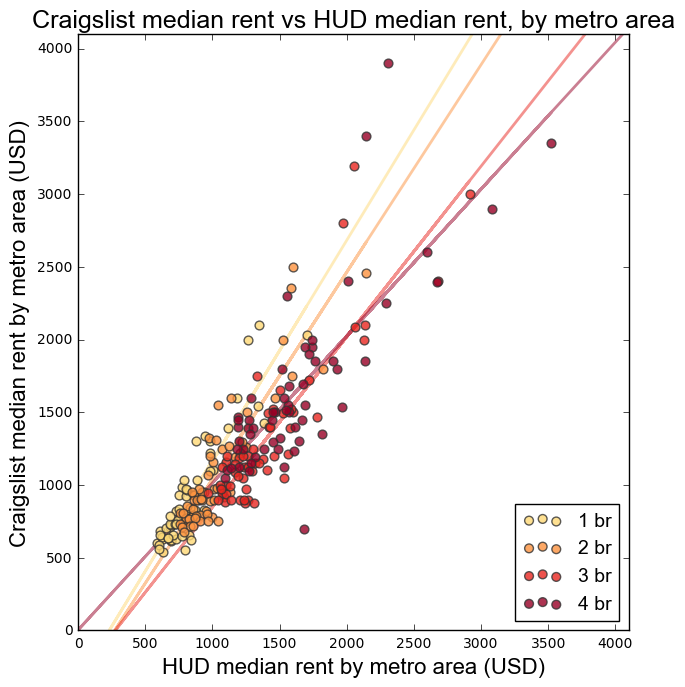

In [87]:
# plot same data, but with simple bivariate regression lines
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
bedrooms = [1, 2, 3, 4]
labels = ['1 br', '2 br', '3 br', '4 br']
color_list = get_colors('YlOrRd', n=len(labels), start=0.25, stop=0.95)
plots = []

for br, c in zip(bedrooms, color_list):
    
    # regress craigslist data on HUD data
    X = region_hud['HUD_median_{}'.format(br)]
    Y = region_hud['clist_{}'.format(br)]
    results = sm.OLS(Y, sm.add_constant(X)).fit()
    
    # calculate estimated y values for regression line
    X_line = pd.Series(X)
    X_line.loc[0] = 0
    X_line.loc[4100] = 4100
    Y_est = X_line * results.params[1] + results.params[0]
    
    # draw points and regression line
    plots.append(ax.scatter(X, Y, c=c, edgecolor='#333333', alpha=0.8, s=40, zorder=2))
    ax.plot(X_line, Y_est, c=c, alpha=0.5, linewidth=2, zorder=1)

ax.set_xlim([0,4100])
ax.set_ylim([0,4100])

ax.set_title('Craigslist median rent vs HUD median rent, by metro area', fontproperties=title_font)
ax.set_xlabel('HUD median rent by metro area (USD)', fontproperties=label_font)
ax.set_ylabel('Craigslist median rent by metro area (USD)', fontproperties=label_font)
plt.legend(plots, labels, loc=4, prop=ticks_font)

save_fig(plt.gcf(), 'median_rent_hud_craigslist_regression.png')
plt.show()

In [88]:
# now get the correlation coefficient and statistical significance for each number of bedrooms
N = len(region_hud)
for br in [1, 2, 3, 4]:
    r, p = pearsonr(region_hud['clist_{}'.format(br)], region_hud['HUD_median_{}'.format(br)])
    r_square = r ** 2
    t = r * (np.sqrt((N - 2)/(1 - r_square)))
    
    print('{} br:'.format(br), 'r={:0.2f},'.format(r), 'r-square={:.2f},'.format(r_square),)
    print('t={:05.2f},'.format(t), 'df={},'.format(N-2), 'p={:0.23f}'.format(p))

1 br: r=0.91, r-square=0.83,
t=16.27, df=56, p=0.00000000000000000000007
2 br: r=0.90, r-square=0.81,
t=15.52, df=56, p=0.00000000000000000000060
3 br: r=0.88, r-square=0.77,
t=13.70, df=56, p=0.00000000000000000015655
4 br: r=0.79, r-square=0.63,
t=09.73, df=56, p=0.00000000000012291089347


The correlations between HUD and Craigslist median rents are positive, strong, and statistically significant (p<.0001). The coefficient of determinations (r<sup>2</sup>) reveal that 83%, 81%, 77%, and 63% (for 1, 2, 3, and 4 bedroom listings, respectively) of the variation in Craigslist median rents (per region) can be explained by HUD median rents.

Now perform a dependent samples t-test for each number of bedrooms to compare the Craigslist and HUD means (of median rents by region) to see if they are significantly different from each other.

In [89]:
# dependent samples t-test to see if means are significantly different
for br in [1, 2, 3, 4]:
    t, p = ttest_rel(region_hud['clist_{}'.format(br)], region_hud['HUD_median_{}'.format(br)])
    print(br, 'br:', 't={},'.format(round(t, 2)), 'p={}'.format(round(p, 3)))

1 br: t=3.22, p=0.002
2 br: t=1.85, p=0.07
3 br: t=-2.43, p=0.018
4 br: t=0.41, p=0.685


The null hypothesis H<sub>0</sub> is that the means are the same. We can reject the null for 1 br (p<.01) and 3 br (p<.02), indicating that the means of Craigslist and HUD are statistically significantly different. We cannot reject the null for 2 br (p=.07) or 4 br (p=.69), indicating that the means of Craigslist and HUD are not statistically significantly different (ie, we would expect a t-statistic of this size 7% and 69% of the time when there is no real difference between the population means).

Two-sample t-tests require that a set of conditions be met. First, each sample must be simple random sampling - ours aren't exactly that. Second, the sampling distribution should be normal - ie, symmetric, unskewed, and without outliers. None of these samples are normally distributed - that's to be expected with real world data. But most of these samples are considerably positively skewed by outliers, so the t-test may not really be appropriate here.

Instead, let's try to get at the degree and direction of bias of Craigslist median rents with regards to HUD median rents by examining ratios.

In [90]:
# now calculate the ratio of median rents in filtered data set (per region and per # of bedrooms) to HUD median rents
region_hud['hud_ratio_1'] = region_hud['clist_1'] / region_hud['HUD_median_1']
region_hud['hud_ratio_2'] = region_hud['clist_2'] / region_hud['HUD_median_2']
region_hud['hud_ratio_3'] = region_hud['clist_3'] / region_hud['HUD_median_3']
region_hud['hud_ratio_4'] = region_hud['clist_4'] / region_hud['HUD_median_4']

region_hud_means = region_hud[['hud_ratio_1','hud_ratio_2','hud_ratio_3','hud_ratio_4']].mean()
region_hud_means

hud_ratio_1    1.074574
hud_ratio_2    1.031968
hud_ratio_3    0.928250
hud_ratio_4    1.012225
dtype: float64

On average (arithmetic mean) in these regions, median rents in the filtered data set are 7.5% higher for 1 bedroom, 3.2% higher for 2 bedrooms, 7.2% lower for 3 bedrooms, and 1.2% higher for 4 bedrooms than the HUD 2014 median rent.

In [91]:
# add the mean values to the bottom then format all the ratios as +/- percentages
region_hud_means.name='means'
region_hud = region_hud.append(region_hud_means)
cols = ['hud_ratio_1','hud_ratio_2','hud_ratio_3','hud_ratio_4']
region_hud[cols] = region_hud[cols].applymap(lambda x: round(x, 2)).values
region_hud[cols].tail()

,hud_ratio_1,hud_ratio_2,hud_ratio_3,hud_ratio_4
region,,,,
tampa,0.93,0.89,0.85,0.87
tucson,0.85,0.84,0.78,0.84
tulsa,0.93,0.87,0.91,1.22
washingtondc,1.15,1.10,0.94,0.90
means,1.07,1.03,0.93,1.01


In [93]:
# save to csv and remove the means row
region_hud.to_csv('data/regions_hud_summary.csv')
region_hud = region_hud.drop(labels='means', axis=0)

## Next, analyze listings counts and median rent per sq ft, by day of the week

In [94]:
days_of_the_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [95]:
# how many times does each day of the week appear in the data set of filtered listings
listings_per_day = filtered_listings.groupby('day_of_week').size()
listings_per_day.index = days_of_the_week
listings_per_day

Monday       508478
Tuesday      522559
Wednesday    498363
Thursday     467710
Friday       394111
Saturday     298688
Sunday       257852
dtype: int64

In [96]:
# how many times does each day of the week appear in the data set of filtered listings
listings_per_date = pd.DataFrame(filtered_listings['date'].value_counts())
listings_per_date['day_of_week'] = listings_per_date.index.weekday
day_counts = listings_per_date['day_of_week'].value_counts().sort_index()
day_counts.index = days_of_the_week
day_counts

Monday       10
Tuesday      10
Wednesday    10
Thursday     10
Friday        9
Saturday      9
Sunday       10
Name: day_of_week, dtype: int64

In [97]:
# how many filtered listings per day of the week normalized by how many times that day appears in the data set
avg_listings_per_day = listings_per_day / day_counts
avg_listings_per_day.name = 'avg_count_filtered'

In [98]:
# what is the median rent per day of the week
median_rent_per_day = filtered_listings.groupby('day_of_week')['rent_sqft'].median().sort_index()
median_rent_per_day.index = days_of_the_week
median_rent_per_day.name = 'median_rent_filtered'

In [99]:
# display a summary of the filtered data set, by day of the week
day_summaries = pd.concat(objs=[avg_listings_per_day, median_rent_per_day], axis=1)
day_summaries

,avg_count_filtered,median_rent_filtered
Monday,50847.800000,1.093750
Tuesday,52255.900000,1.092448
Wednesday,49836.300000,1.077185
Thursday,46771.000000,1.097608
Friday,43790.111111,1.102941
Saturday,33187.555556,1.166407
Sunday,25785.200000,1.200781


The average number of listings posted and the median rent per square foot, per day of the week (filtered data set)

In [100]:
# for comparison, create the same dataframe above, but for the original thorough set of listings
all_listings_per_day = all_listings.groupby(all_listings['day_of_week']).size()
all_listings_per_day.index = days_of_the_week
all_listings_per_date = pd.DataFrame(all_listings['date'].value_counts())
all_listings_per_date['day_of_week'] = all_listings_per_date.index.weekday
all_day_counts = all_listings_per_date['day_of_week'].value_counts().sort_index()
all_day_counts.index = days_of_the_week
all_avg_listings_per_day = all_listings_per_day / all_day_counts
all_avg_listings_per_day.name = 'avg_count_original'
all_median_rent_per_day = all_listings.groupby(all_listings['day_of_week'])['rent_sqft'].median().sort_index()
all_median_rent_per_day.index = days_of_the_week
all_median_rent_per_day.name = 'median_rent_original'
all_day_summaries = pd.concat(objs=[all_avg_listings_per_day, all_median_rent_per_day], axis=1)

In [101]:
# compare the daily summaries from the original thorough data set, to those of the filtered set
combined_summaries = pd.concat(objs=[day_summaries, all_day_summaries], axis=1)
combined_summaries['count_ratio'] = combined_summaries['avg_count_filtered'] / combined_summaries['avg_count_original']
combined_summaries['rent_ratio'] = combined_summaries['median_rent_filtered'] / combined_summaries['median_rent_original']
combined_summaries = combined_summaries.reindex(columns=['avg_count_filtered','avg_count_original','count_ratio',
                                                         'median_rent_filtered','median_rent_original','rent_ratio'])
combined_summaries

,avg_count_filtered,avg_count_original,count_ratio,median_rent_filtered,median_rent_original,rent_ratio
Monday,50847.800000,201440.800000,0.252421,1.093750,1.071429,1.020833
Tuesday,52255.900000,180839.000000,0.288964,1.092448,1.078125,1.013285
Wednesday,49836.300000,180904.500000,0.275484,1.077185,1.062112,1.014192
Thursday,46771.000000,174073.200000,0.268686,1.097608,1.074324,1.021673
Friday,43790.111111,166125.666667,0.263596,1.102941,1.083333,1.018100
Saturday,33187.555556,120580.888889,0.275231,1.166407,1.129146,1.033000
Sunday,25785.200000,100543.800000,0.256457,1.200781,1.187500,1.011184


The average number of listings posted and the median rent per square foot, by day of the week, for the original thorough data set and the filtered data set. Ratios show the ratio of the filtered set's value to the original set's value.

Tuesdays have a noticeably higher ratio of unique, reasonable rental listings posted compared to Mondays. Explore that further, below.

In [102]:
# for more comparison, create the same dataframe as earlier, but for the unique set of listings, pre-filter
unique_listings_per_day = unique_listings.groupby(unique_listings['day_of_week']).size()
unique_listings_per_day.index = days_of_the_week
unique_listings_per_date = pd.DataFrame(unique_listings['date'].value_counts())
unique_listings_per_date['day_of_week'] = unique_listings_per_date.index.weekday
unique_day_counts = unique_listings_per_date['day_of_week'].value_counts().sort_index()
unique_day_counts.index = days_of_the_week
unique_avg_listings_per_day = unique_listings_per_day / unique_day_counts
unique_avg_listings_per_day.name = 'avg_count_unique'
unique_median_rent_per_day = unique_listings.groupby(unique_listings['day_of_week'])['rent_sqft'].median().sort_index()
unique_median_rent_per_day.index = days_of_the_week
unique_median_rent_per_day.name = 'median_rent_unique'
unique_day_summaries = pd.concat(objs=[unique_avg_listings_per_day, unique_median_rent_per_day], axis=1)

In [103]:
# look at the ratios (original, unique, and filtered) side by side
all_ratios = combined_summaries['avg_count_original'] / combined_summaries['avg_count_original'].sum()
unique_ratios = unique_day_summaries['avg_count_unique'] / unique_day_summaries['avg_count_unique'].sum()
filtered_ratios = combined_summaries['avg_count_filtered'] / combined_summaries['avg_count_filtered'].sum()

avg_count_ratios = pd.concat(objs=[all_ratios, unique_ratios, filtered_ratios], axis=1)
avg_count_ratios = avg_count_ratios.rename(columns={'avg_count_original':'original', 
                                                    'avg_count_unique':'unique', 
                                                    'avg_count_filtered':'filtered'})
avg_count_ratios

,original,unique,filtered
Monday,0.179137,0.174399,0.168106
Tuesday,0.160816,0.175510,0.172762
Wednesday,0.160874,0.162347,0.164762
Thursday,0.154799,0.153566,0.154628
Friday,0.147732,0.142282,0.144773
Saturday,0.107230,0.104089,0.109720
Sunday,0.089411,0.087806,0.085248


TypeError: object of type 'map' has no len()

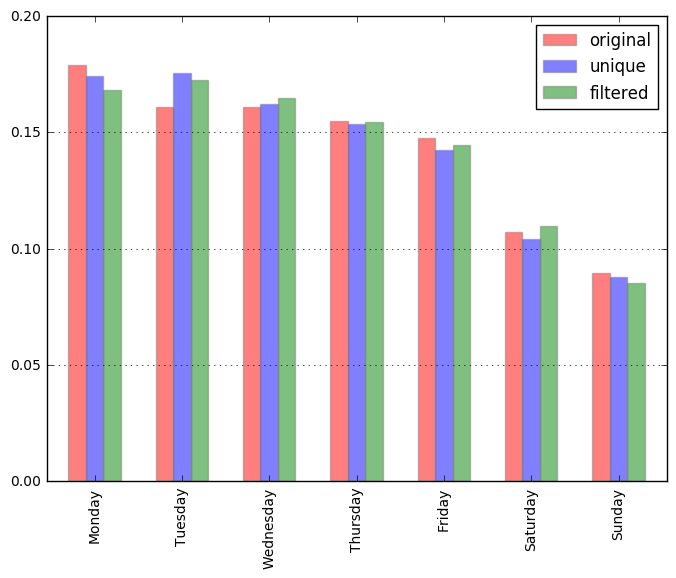

In [104]:
# plot the ratios of rental listings (original, unique, and filtered) by day of week
countdata = avg_count_ratios
ax = countdata.plot(kind='bar',                 
                    figsize=[8, 6], 
                    ylim=[0,.2],
                    width=0.6, 
                    alpha=0.5,
                    color=['r','b','g'],
                    edgecolor='gray',
                    grid=False)

ax.yaxis.grid(True)
ax.set_xticks(map(lambda x: x, range(0, len(countdata))))
ax.set_xticklabels(countdata.index, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
ax.set_title('Each day of the week\'s ratio of total rental listings posted', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Ratio of listings posted per day', fontproperties=label_font)

save_fig(plt.gcf(), 'day_of_week_ratio_listings_posted.png')
plt.show()

Here it is easy to see that Mondays account for a greater proportion of posted rental listings before we filter the data set for duplicates/re-posts and reasonable values. In contrast, Tuesdays account for a greater proportion of the listings after we filter the data set. It seems that Mondays suffer from more low quality postings, and Tuesdays have a greater ratio of high quality postings.

TypeError: object of type 'map' has no len()

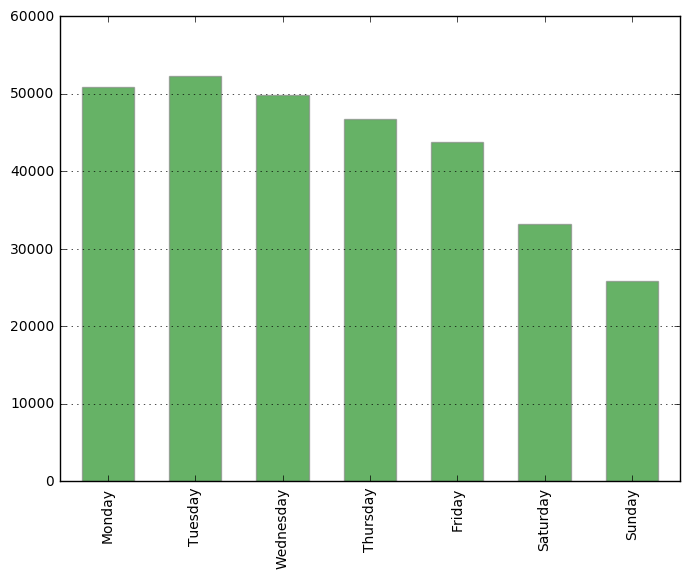

In [105]:
# plot the avg number of filtered rental listings, by day of week
countdata = avg_listings_per_day
ax = countdata.plot(kind='bar',                 
                    figsize=[8, 6], 
                    width=0.6, 
                    alpha=0.6,
                    color='g',
                    edgecolor='gray',
                    grid=False)

ax.yaxis.grid(True)
ax.set_xticks(map(lambda x: x, range(0, len(countdata))))
ax.set_xticklabels(countdata.index, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
ax.set_title('Filtered rental listings posted, by day of the week', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Mean listings posted per day', fontproperties=label_font)

save_fig(plt.gcf(), 'day_of_week_listings_count_posted_filtered.png')
plt.show()

Sundays see only half as many (filtered) listings posted as Mondays and Tuesdays do.

## Now look at median rent/sqft by day of the week

In [106]:
# look at the median rent/sqft (original, unique, and filtered) side by side
all_rent = combined_summaries['median_rent_original']
unique_rent = unique_day_summaries['median_rent_unique']
filtered_rent = combined_summaries['median_rent_filtered']

median_rents = pd.concat(objs=[all_rent, unique_rent, filtered_rent], axis=1)
median_rents = median_rents.rename(columns={'median_rent_original':'original', 
                                                    'median_rent_unique':'unique', 
                                                    'median_rent_filtered':'filtered'})
median_rents

,original,unique,filtered
Monday,1.071429,1.093750,1.093750
Tuesday,1.078125,1.092694,1.092448
Wednesday,1.062112,1.077410,1.077185
Thursday,1.074324,1.097802,1.097608
Friday,1.083333,1.102941,1.102941
Saturday,1.129146,1.166329,1.166407
Sunday,1.187500,1.200608,1.200781


TypeError: object of type 'map' has no len()

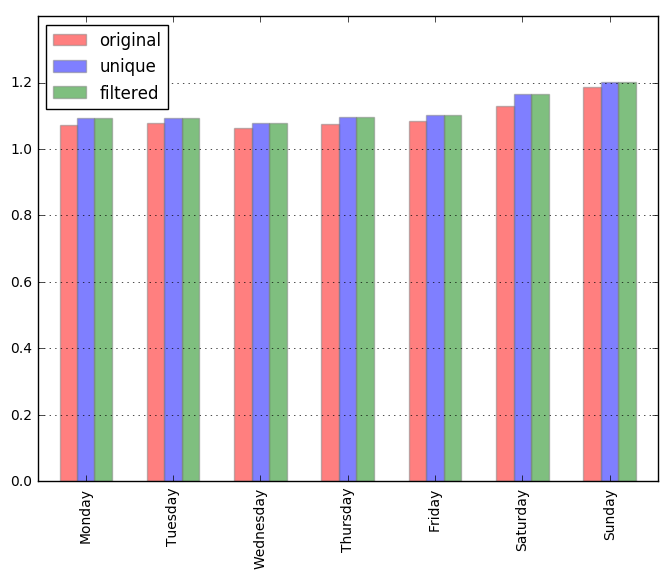

In [107]:
# plot the median rent/sqft (original, unique, and filtered) by day of week
countdata = median_rents
ax = countdata.plot(kind='bar',                 
                    figsize=[8, 6], 
                    ylim=[0, 1.4],
                    width=0.6, 
                    alpha=0.5,
                    color=['r','b','g'],
                    edgecolor='gray',
                    grid=False)

ax.yaxis.grid(True)
ax.set_xticks(map(lambda x: x, range(0, len(countdata))))
ax.set_xticklabels(countdata.index, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
ax.set_title('Median rent per square foot, by day of the week posted', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Median rent per square foot (USD)', fontproperties=label_font)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left')

save_fig(plt.gcf(), 'day_of_week_median_rent_sqft.png')
plt.show()

TypeError: object of type 'map' has no len()

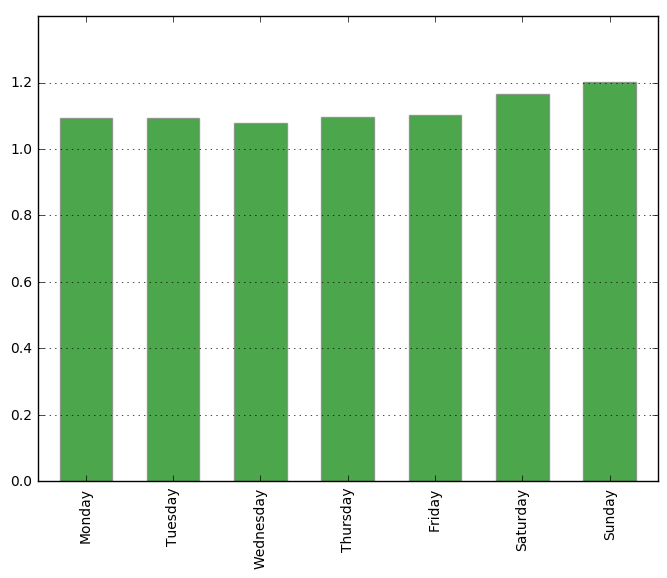

In [108]:
# plot the median rent per sq ft by day of the week for the filtered data set only
countdata = median_rent_per_day
ax = countdata.plot(kind='bar',                 
                    figsize=[8, 6], 
                    width=0.6, 
                    alpha=0.7,
                    color='g',
                    edgecolor='gray',
                    grid=False,
                    ylim=[0, 1.4])

ax.yaxis.grid(True)
ax.set_xticks(map(lambda x: x, range(0, len(countdata))))
ax.set_xticklabels(countdata.index, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
ax.set_title('Median rent per square foot, by day of the week', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Median rent per square foot (USD)', fontproperties=label_font)

save_fig(plt.gcf(), 'day_of_week_median_rent_sqft_filtered.png')
plt.show()

Median rents are about 11.5% higher on Sundays (the most expensive day) than they are on Wednesdays (the least expensive day)

## Retain only the rows with lat-long data, then show descriptive stats for the different stages of the data set

In [109]:
# clean data further by only retaining rows with lat-long data
geolocated_filtered_listings = pd.DataFrame(filtered_listings)
geolocated_filtered_listings = geolocated_filtered_listings[pd.notnull(geolocated_filtered_listings['latitude'])]
geolocated_filtered_listings = geolocated_filtered_listings[pd.notnull(geolocated_filtered_listings['longitude'])]

print(len(geolocated_filtered_listings))
print(len(geolocated_filtered_listings) / float(len(filtered_listings)))

1456338
0.49404887302600176


There are 1,456,338 geolocated listings in the filtered data set.

To recap:

- There were 10,958,372 rental listings in the original, full data set.
- Of those total listings, 5,480,435 or 50.0% were unique.
- Of those unique listings, 2,947,761 or 53.8% had rent, sqft, and reasonable values.
- Of those filtered listings, 1,456,338 or 49.4% were geolocated.

Interestingly, each filtering step retained almost exactly half of the remaining data set.

In [110]:
# how many regions are in the data set?
print(len(all_listings['region'].unique()))
print(len(filtered_listings['region'].unique()))

415
415


In [111]:
print(len(all_listings))
all_listings.describe()

10958372


,Unnamed: 0,rent,bedrooms,sqft,longitude,latitude,rent_sqft,day_of_week
count,1.095837e+07,1.042887e+07,9.637250e+06,5.414188e+06,4.353148e+06,4.353148e+06,5.348630e+06,1.095837e+07
mean,5.479186e+06,1.765311e+04,2.126101e+00,1.202707e+03,-9.589977e+01,3.743741e+01,5.926003e+01,2.563152e+00
std,3.163410e+06,4.937165e+06,1.022632e+00,1.650541e+04,1.826567e+01,5.382645e+00,9.326196e+04,1.909732e+00
min,0.000000e+00,-3.225590e+07,-1.000000e+00,-4.000000e+03,-2.629688e+02,-8.556127e+01,-1.287661e+04,0.000000e+00
25%,2.739593e+06,8.250000e+02,1.000000e+00,7.650000e+02,-1.153314e+02,3.364014e+01,8.071895e-01,1.000000e+00
50%,5.479186e+06,1.295000e+03,2.000000e+00,1.000000e+03,-9.242220e+01,3.845257e+01,1.086142e+00,2.000000e+00
75%,8.218779e+06,1.995000e+03,3.000000e+00,1.295000e+03,-8.018000e+01,4.159858e+01,1.693182e+00,4.000000e+00
max,1.095837e+07,2.147484e+09,8.000000e+00,8.388607e+06,1.000000e+03,1.032691e+02,2.147484e+08,6.000000e+00


In [112]:
print(len(unique_listings))
unique_listings.describe()

5480435


,Unnamed: 0,rent,bedrooms,sqft,longitude,latitude,rent_sqft,day_of_week
count,5.480435e+06,5.250063e+06,4.833635e+06,3.005085e+06,2.335741e+06,2.335741e+06,2.971497e+06,5.480435e+06
mean,5.161900e+06,2.277419e+04,2.079629e+00,1.182798e+03,-9.714209e+01,3.746902e+01,9.891027e+01,2.530704e+00
std,3.308063e+06,5.677344e+06,9.954867e-01,1.949706e+04,1.861646e+01,5.298195e+00,1.250823e+05,1.897608e+00
min,0.000000e+00,-3.225590e+07,-1.000000e+00,-4.000000e+03,-2.629688e+02,-8.556127e+01,-1.287661e+04,0.000000e+00
25%,2.193060e+06,8.000000e+02,1.000000e+00,7.560000e+02,-1.172457e+02,3.368864e+01,8.213892e-01,1.000000e+00
50%,5.061109e+06,1.246000e+03,2.000000e+00,9.820000e+02,-9.457040e+01,3.800383e+01,1.106520e+00,2.000000e+00
75%,8.020552e+06,1.900000e+03,3.000000e+00,1.233000e+03,-8.026440e+01,4.113710e+01,1.709156e+00,4.000000e+00
max,1.095837e+07,2.147484e+09,8.000000e+00,8.388607e+06,1.000000e+03,1.032691e+02,2.147484e+08,6.000000e+00


In [113]:
print(len(thorough_listings))
thorough_listings.describe()

2971362


,Unnamed: 0,rent,bedrooms,sqft,longitude,latitude,rent_sqft,day_of_week
count,2.971362e+06,2.971362e+06,2.824335e+06,2.971362e+06,1.466834e+06,1.466834e+06,2.971362e+06,2.971362e+06
mean,5.246253e+06,1.099428e+04,2.055445e+00,1.182688e+03,-1.005398e+02,3.712059e+01,9.891925e+01,2.557981e+00
std,3.299778e+06,3.090407e+06,9.397804e-01,1.958283e+04,1.806001e+01,5.318896e+00,1.250851e+05,1.887512e+00
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-2.629688e+02,-8.556127e+01,1.000001e-06,0.000000e+00
25%,2.316028e+06,8.000000e+02,1.000000e+00,7.550000e+02,-1.178594e+02,3.354223e+01,8.214286e-01,1.000000e+00
50%,5.167172e+06,1.145000e+03,2.000000e+00,9.820000e+02,-9.779670e+01,3.727912e+01,1.106557e+00,2.000000e+00
75%,8.103044e+06,1.695000e+03,3.000000e+00,1.234000e+03,-8.286183e+01,4.043184e+01,1.709160e+00,4.000000e+00
max,1.095837e+07,2.147484e+09,8.000000e+00,8.388607e+06,1.000000e+03,1.032691e+02,2.147484e+08,6.000000e+00


In [114]:
print(len(filtered_listings))
filtered_listings.describe()

2947761


,Unnamed: 0,rent,bedrooms,sqft,longitude,latitude,rent_sqft,day_of_week
count,2.947761e+06,2.947761e+06,2.803888e+06,2.947761e+06,1.456338e+06,1.456338e+06,2.947761e+06,2.947761e+06
mean,5.244388e+06,1.381766e+03,2.052075e+00,1.084518e+03,-1.005463e+02,3.712425e+01,1.389771e+00,2.557674e+00
std,3.300222e+06,8.709270e+02,9.338902e-01,5.125596e+02,1.805473e+01,5.318279e+00,8.570999e-01,1.887126e+00
min,0.000000e+00,1.900000e+02,1.000000e+00,2.210000e+02,-2.629688e+02,-8.556127e+01,1.004464e-01,0.000000e+00
25%,2.314629e+06,8.000000e+02,1.000000e+00,7.570000e+02,-1.178629e+02,3.354290e+01,8.235294e-01,1.000000e+00
50%,5.163853e+06,1.145000e+03,2.000000e+00,9.820000e+02,-9.779699e+01,3.728166e+01,1.106428e+00,2.000000e+00
75%,8.102445e+06,1.695000e+03,3.000000e+00,1.230000e+03,-8.286640e+01,4.043187e+01,1.702733e+00,4.000000e+00
max,1.095837e+07,1.028500e+04,8.000000e+00,5.197000e+03,1.000000e+03,1.032691e+02,1.260504e+01,6.000000e+00


In [115]:
print(len(geolocated_filtered_listings))
geolocated_filtered_listings.describe()

1456338


,Unnamed: 0,rent,bedrooms,sqft,longitude,latitude,rent_sqft,day_of_week
count,1.456338e+06,1.456338e+06,1.386600e+06,1.456338e+06,1.456338e+06,1.456338e+06,1.456338e+06,1.456338e+06
mean,4.054466e+06,1.341977e+03,2.039867e+00,1.070163e+03,-1.005463e+02,3.712425e+01,1.357754e+00,2.663623e+00
std,3.006042e+06,8.178813e+02,9.249705e-01,5.060861e+02,1.805473e+01,5.318279e+00,7.868383e-01,1.989451e+00
min,1.000000e+00,1.900000e+02,1.000000e+00,2.210000e+02,-2.629688e+02,-8.556127e+01,1.004464e-01,0.000000e+00
25%,1.385318e+06,7.990000e+02,1.000000e+00,7.500000e+02,-1.178629e+02,3.354290e+01,8.312500e-01,1.000000e+00
50%,3.284779e+06,1.115000e+03,2.000000e+00,9.600000e+02,-9.779699e+01,3.728166e+01,1.101471e+00,2.000000e+00
75%,6.739857e+06,1.650000e+03,3.000000e+00,1.205000e+03,-8.286640e+01,4.043187e+01,1.664706e+00,4.000000e+00
max,1.077971e+07,1.028500e+04,8.000000e+00,5.192000e+03,1.000000e+03,1.032691e+02,1.260504e+01,6.000000e+00


## Finally, save the geolocated filtered data to CSV for GIS mapping

In [116]:
# only retain the relevant columns, then save the dataframe to csv
cols = ['pid', 'date', 'region', 'neighborhood', 'rent', 'bedrooms', 'sqft', 'rent_sqft', 
        'rent_sqft_cat', 'longitude', 'latitude']
data_output = geolocated_filtered_listings[cols]
data_output.to_csv('data/geolocated_filtered_listings.csv', index=False)

In [117]:
# also save a minimized csv with only category, lat, and long
min_cols = ['rent_sqft_cat', 'longitude', 'latitude']
data_output_min = geolocated_filtered_listings[min_cols]
data_output_min.to_csv('data/geolocated_filtered_listings_min.csv', index=False)